# Gravitational Wave Analysis and Detection

In this notebook, an implementation is made on the analysis and detection of gravitational waves using spectrogram representation of the samples in the <a href='https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/data'>G2NET dataset</a>.

In this implementation, the spectrogram of the wave signals are computed with the Constant Q Transform algorthim offered by <a href="https://kinwaicheuk.github.io/nnAudio/index.html">nnAudio</a> module.

In [1]:
!pip install nnAudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.1 MB/s eta 0:00:00


Below the relevant modules for this implementation are imported. A thing to note is that <a href='https://docs.cupy.dev/en/stable/'>cupy</a> and <a href='https://docs.rapids.ai/api/cudf/stable/'>cudf</a> modules are used instead of numpy and pandas, as they are GPU variants and execute much more faster.

In [2]:
import cupy as cp
import cudf as cd
import os, tqdm, torch, torchvision, gc, random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nnAudio.features import CQT

# Data Loading and Exploratory Data Analysis

The dataset consist of '.npy' files aranged in a nested manner inside the train folder. Here the os module is used to iterate efficiently through the nested files to get the file paths and their file names corresponding to the variables *data_paths* and *data_ids* in the program below.

In [3]:
def get_data_info(root_path: str):
    data_paths = []
    data_ids = []
    for path, subdirs, files in tqdm.tqdm(os.walk(root_path)):
        for name in files:
            data_paths.append(os.path.join(path, name))
            data_ids.append(name.replace('.npy', ''))
            
    return data_paths, data_ids

train_dir = '../input/g2net-gravitational-wave-detection'
data_paths, data_ids = get_data_info(os.path.join(train_dir, 'train'))

4369it [01:06, 65.97it/s]


Next, the 'training_labels.csv' file is loaded. This spreadsheet file has two columns 'id' and 'target'. The 'id' column corresponds to the file names without their file extensions and the 'target' column contains annotations of 0s and 1s corresponding to whether gravitational wave signal is abscent in the signal waveform or not respectively.

In [4]:
training_labels = cd.read_csv(os.path.join(train_dir, 'training_labels.csv'))
training_labels.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


The code below checks for the presence of *NA* values in the 'train_labels.csv' file.

In [5]:
training_labels.isna().sum()

id        0
target    0
dtype: int64

No *NA* values were found in the labels file. Next a countplot is made to visualise the level of target imbalance in the labels file if any.

length of target 0: 280070 
length of target 1: 279930


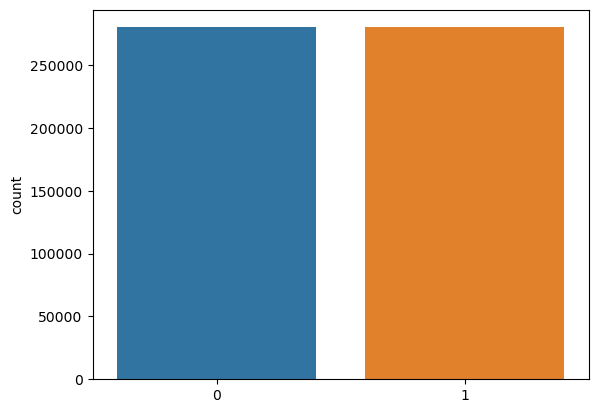

In [6]:
target_0 = training_labels[training_labels['target'] == 0]
target_1 = training_labels[training_labels['target'] == 1]
print(f'length of target 0: {len(target_0)} \nlength of target 1: {len(target_1)}')

ax = sns.countplot(x=training_labels['target'].values.get())

From the plot, it is observed that the target classes are relatively balanced with 280070 0s and 279930 1s.

Below the waveform of some given samples are visualised in a graphical plot. Each sample consists of three waveforms corresponding to simulated signal + noise of three different Interferometers corresponding to Handford LIGO, Livington LIGO and Virgo.

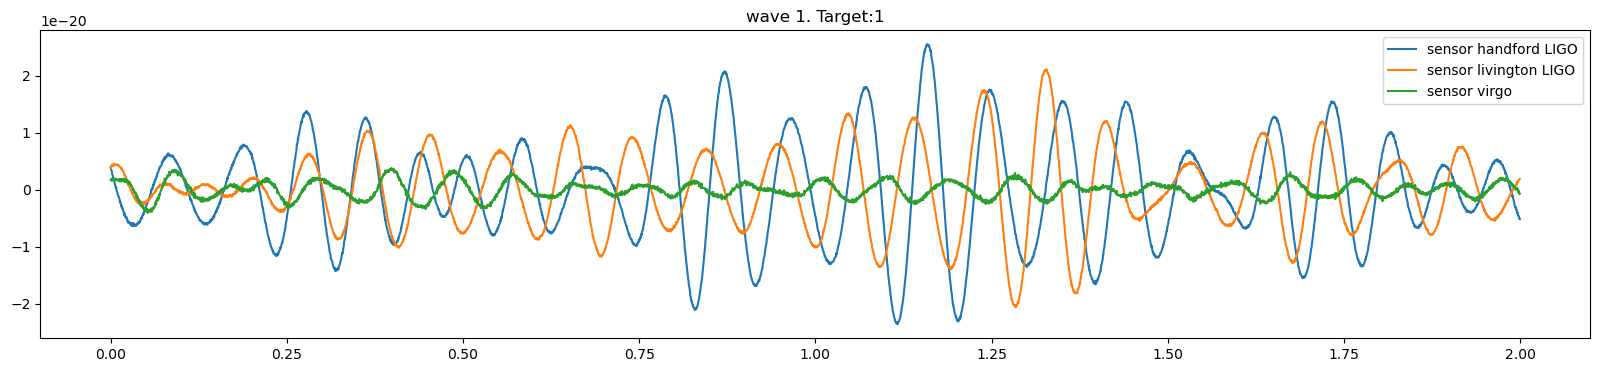

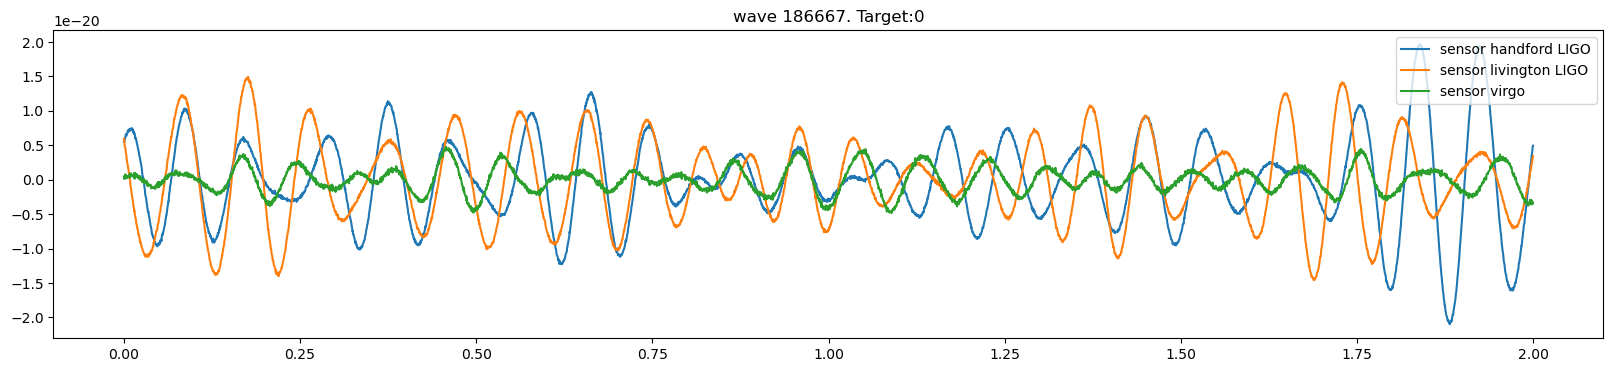

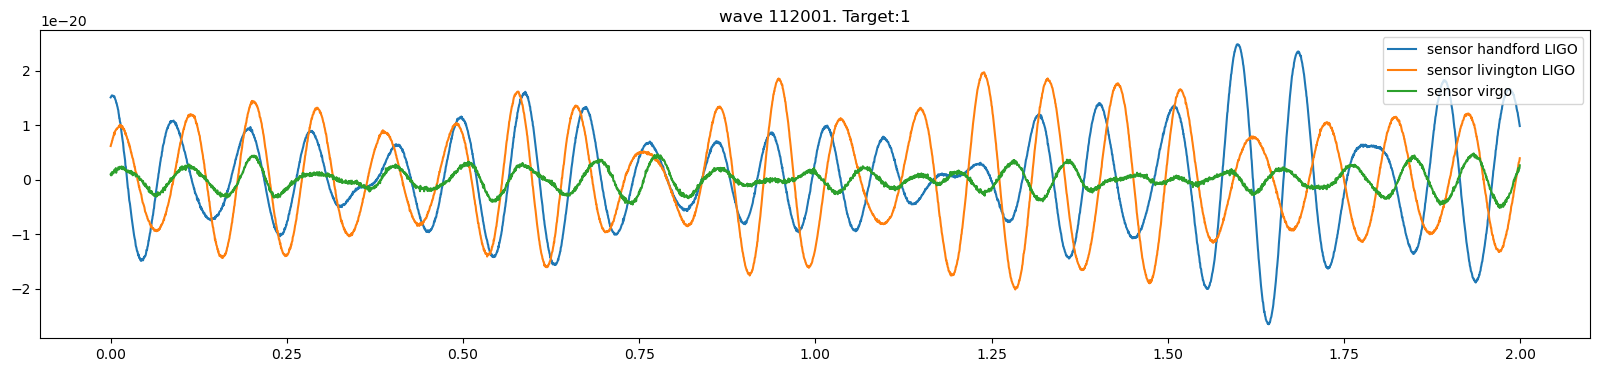

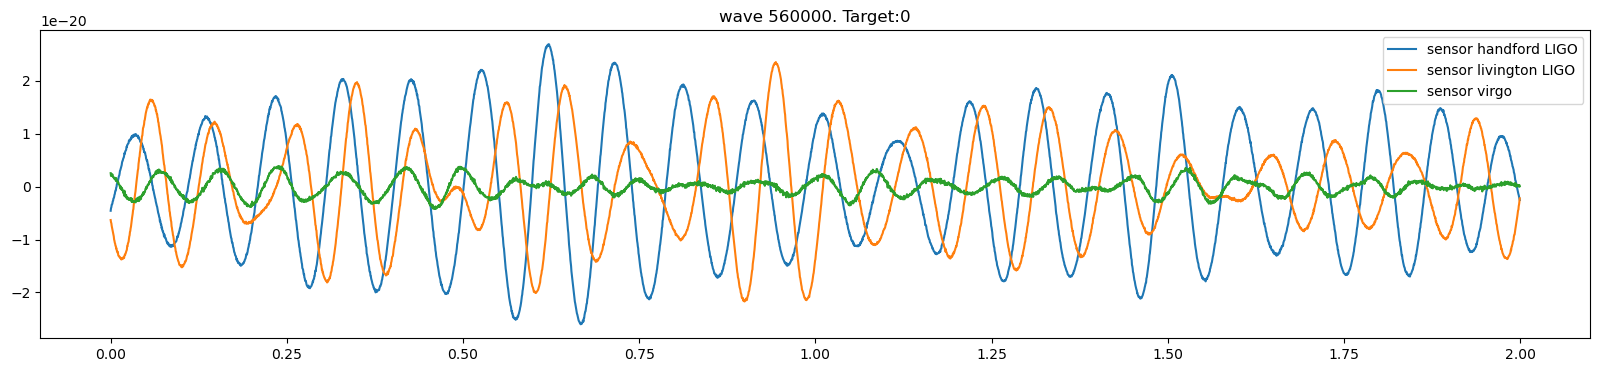

In [7]:
plot_idx = [0, len(data_paths)//3, len(data_paths)//5, len(data_paths)-1]
sensors = ['handford LIGO', 'livington LIGO', 'virgo']
sample_freq = 2048
timesteps = cp.arange(0, 2, 1/sample_freq).get()

for i, sample_idx in enumerate(plot_idx):
    signals = cp.load(data_paths[sample_idx]).get()
    target = training_labels[training_labels['id'] == data_ids[sample_idx]]['target'].values[0]
    fig = plt.figure(figsize=(20, 4))
    for j, signal in enumerate(signals):
        plt.plot(timesteps, signal, label=f'sensor {sensors[j]}')
        plt.title(f'wave {sample_idx+1}. Target:{target}')
        plt.legend(loc='upper right')
    plt.plot()

The histograms of the selected samples from above are plotted in the next code cell so as to get an overview of the distribution and width of variance of the signal readings of each detector.

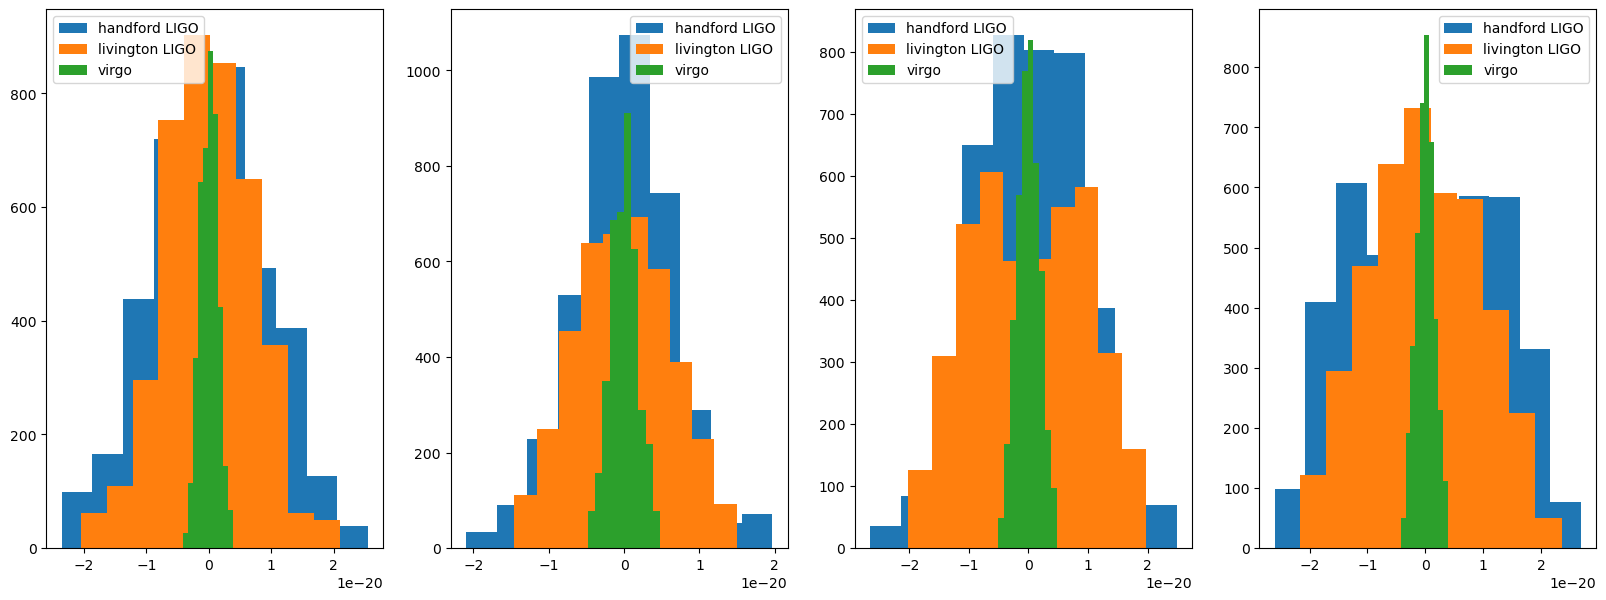

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 7))

for i, sample_idx in enumerate(plot_idx):
    axs[i].hist(cp.load(data_paths[sample_idx]).get()[0], label=f'{sensors[0]}')
    axs[i].hist(cp.load(data_paths[sample_idx]).get()[1], label=f'{sensors[1]}')
    axs[i].hist(cp.load(data_paths[sample_idx]).get()[2], label=f'{sensors[2]}')
    axs[i].legend()

It is observed that the distribution of the signal readings of the Virgo detector look skewered with relatively very small variance compared to the Handford and Livington detectors.

In the code cell below, the *SignalDataset()* class is instantiated and is a derived class from the *torch.utils.data.Dataset()* class. This class object is responsible for lazy loading of the dataset. The lazy loading approach was adopted because the dataset was too big and could not fit into the available RAM, making eager loading of large number of samples difficult.

The class returns the spectrogram of any given sample and it's corresponding target class via the *__getitem__()* method. In the *SignalDataset()* class, an object of the *CQT()* class from the *nnAudio* module is instantiated. maximum and minimum frequencies of 20Hz and 500Hz respectively are assumed, the sampling rate (sr) attribute is also set to 2048Hz and the hop length to 64.

The spectrogram is computed in the *preprocess()* method, this method takes the single sample and horizontally stacks the signals of the three differenct detectors into a single vector and computes the spectrogram. The idea behind stacking all signals in a sample horizontally is that a given sample whose target is 1 corresponding to presence of gravitational wave will have similar repeating frequencies along some given time intervals in the spectrogram.

In [9]:
class SignalDataset(Dataset):
    def __init__(self, paths, ids=None):
        self.paths = paths
        self.ids = ids
        self.CQT_transform = CQT(
            sr=2048,
            fmin=20,           
            fmax=500,
            hop_length=64,
            verbose=False
        )
        
    def __getitem__(self, idx):
        X = cp.load(self.paths[idx])
        X = self.preprocess(X)
        if self.ids != None:
            y = training_labels[training_labels['id'] == self.ids[idx]]['target'].values[0]
            return X, y.get()
        return X
        
    def preprocess(self, signals):
        for i, signal in enumerate(signals):
            signals[i] /= signal.max()
        signals = cp.hstack(signals)
        signal = torch.FloatTensor(signals)
        #shape: C, Freq, Time
        spectrogram = self.CQT_transform(signal)
        return spectrogram
    
    def __len__(self):
        return len(self.paths)

The generated spectrograms of some selected samples are plotted and viewed with the *imshow()* method of the *matplotlib.plyplot()* class below

/opt/conda/lib/python3.10/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


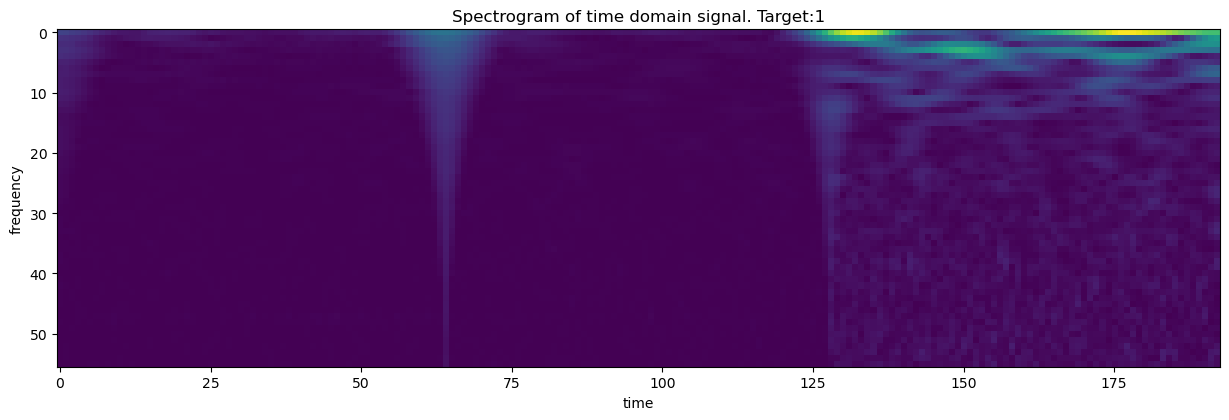

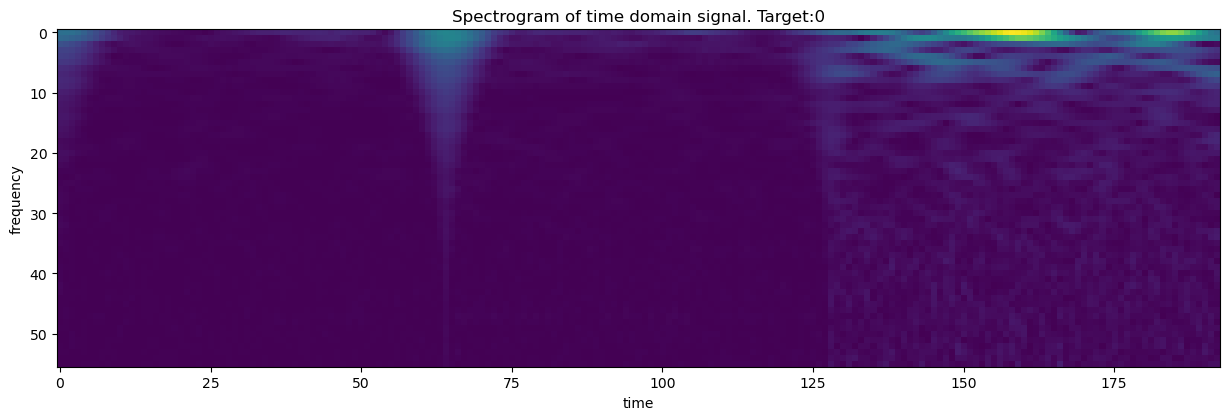

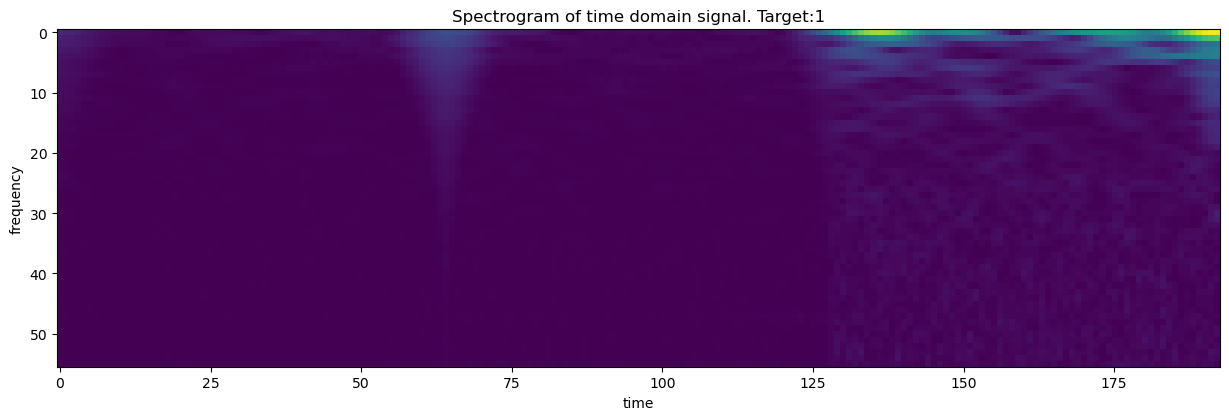

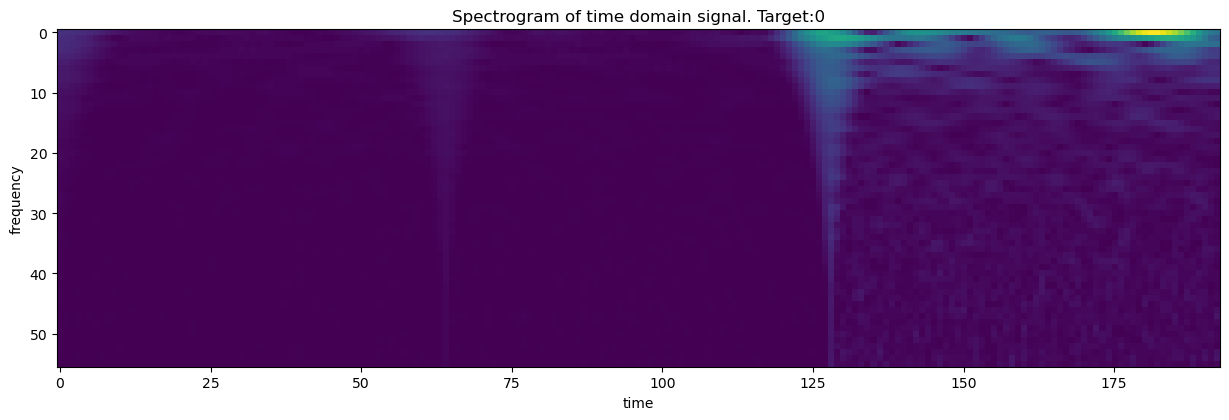

In [10]:
training_dataset = SignalDataset(data_paths, data_ids)

for i in plot_idx:
    sample_cqt, target = training_dataset[i]
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(sample_cqt.permute(1, 2, 0))
    plt.title(f'Spectrogram of time domain signal. Target:{target}')
    plt.xlabel('time')
    plt.ylabel('frequency')
    plt.plot()

# Data Modelling with Artifical Neural Networks

In this section the dataset is modelled with the <a href='https://arxiv.org/abs/1512.03385'>ResNet18 </a> neural network architecture with the <a href='https://pytorch.org/docs/stable/index.html'>Pytorch </a> framework. The ResNet18 architecure in this implementation is modified to have a single input channel at first layer, dropout inbetween blocks and a last fc layer with output feature size of 1

In [11]:
torch.manual_seed(3407)

In [12]:
class ClassifierNet(torch.jit.ScriptModule):
    
    def __init__(self, input_channels, output_features, dropout):
        super(ClassifierNet, self).__init__()
        self.input_channels = input_channels
        self.output_features = output_features
        self.dropout = dropout
        
        self.resnet = torchvision.models.resnet18(pretrained=False)

        self.resnet.conv1 = nn.Conv2d(
            self.input_channels, 
            64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), 
            bias=False)

        self.resnet.fc = nn.Linear(
            in_features=512, 
            out_features=self.output_features, 
            bias=True)
        
        self.add_dropout()
        
        self.sigmoid = nn.Sigmoid()

        
    def add_dropout(self, n_layers=4):
        for i in range(1, n_layers+1):
            layer = list(getattr(self.resnet, f'layer{i}'))
            layer.append(nn.Dropout(self.dropout))
            setattr(self.resnet, f'layer{i}', nn.Sequential(*layer))
        
    
    @torch.jit.script_method
    def forward(self, _input):
        output = self.resnet(_input)
        output = self.sigmoid(output)
        return output


Next the pipeline class is defined for the neural network model training, testing and saving. The *ClassifierPipeline()* class takes as arguments the defined NN model object, the loss function, the optimizer and the device to perform computing on.

In [13]:
class ClassifierPipeline:
    def __init__(self, classifier, lossfunc, optimizer, device='cpu'):
        
        self.classifier = classifier.to(device)
        self.lossfunc = lossfunc
        self.optimizer = optimizer
        self.device = device
        self.classifier.apply(self.init_weights)
    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias:
                m.bias.data.fill_(0.01)
    
    
    def save_model(self, dirname='./model_params', 
                   filename='gravitational_wave_detection_model.pth.tar'):
        if not os.path.isdir(dirname):os.mkdir(dirname)
        state_dicts = {
            'model_params':self.classifier.state_dict(),
            'optimizer_params':self.optimizer.state_dict(),
        }
        return torch.save(state_dicts, os.path.join(dirname, filename))
        
    
    def train(self, dataloader, epochs=1, verbose=False):
        self.classifier.train()
        losses, accuracies = [], []
        for epoch in range(epochs):
            mean_loss, mean_accuracy = 0, 0
            for idx, (signals, target) in tqdm.tqdm(enumerate(dataloader)):
                signals, target = signals.float().to(self.device), target.float().to(self.device)
                optimizer.zero_grad()
                pred = self.classifier(signals)
                pred = pred.reshape(-1)
                loss = self.lossfunc(pred, target)
                loss.backward()
                self.optimizer.step()
                mean_loss += loss.item()
                target = target.to('cpu').numpy()
                pred = torch.round(pred).detach().to('cpu').numpy()
                accuracy = accuracy_score(target, pred)
                mean_accuracy += accuracy
            mean_loss = mean_loss / (idx+1)
            mean_accuracy = mean_accuracy / (idx+1)
            losses.append(mean_loss)
            accuracies.append(mean_accuracy)
            if verbose:
                print(f'epoch: {epoch} \nLoss: {mean_loss}, \naccuracy: {mean_accuracy}')
        return losses, accuracies
    
    
    def test(self, dataloader, verbose=False, return_cm=False):
        actual_vals, pred_vals = [], []
        self.classifier.eval()
        mean_loss, mean_accuracy = 0, 0
        with torch.no_grad():
            for idx, (signals, target) in tqdm.tqdm(enumerate(dataloader)):
                signals, target = signals.float().to(self.device), target.float().to(self.device)
                pred = self.classifier(signals)
                pred = pred.reshape(-1)
                loss = self.lossfunc(pred, target)
                mean_loss += loss.item()
                target = target.to('cpu').numpy()
                pred = torch.round(pred).detach().to('cpu').numpy()
                accuracy = accuracy_score(target, pred)
                             
                if return_cm:
                    actual_vals.append(target)
                    pred_vals.append(pred)
                    
                mean_accuracy += accuracy
            mean_loss = mean_loss / (idx+1)
            mean_accuracy = mean_accuracy / (idx+1)
            if verbose: print(f'Loss: {mean_loss}, \naccuracy: {mean_accuracy}')
                
        if return_cm: 
            actual_vals = torch.cat([torch.from_numpy(i) for i in actual_vals]).numpy().reshape(-1)
            pred_vals = torch.cat([torch.from_numpy(i) for i in pred_vals]).numpy().reshape(-1)
            cm = confusion_matrix(actual_vals, pred_vals)
            return mean_loss, mean_accuracy, cm
        return mean_loss, mean_accuracy

The *Model_CFG* class is defined to hold configuration values for model, optimizer, training and testing proccess, etc.

In [14]:
class Model_CFG:
    input_channels = 1
    output_features = 1
    learning_rate = 5e-2
    weight_decay = 5e-7
    dropout = 0.2
    epochs=30
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 400

Next the *data_paths* and *data_ids* list objects are split into training and testing lists which are used to create two objects of the *SignalDataset* class for training and testing. These created *SignalDataset* objects are used to instantiate two *Dataloader* objects for training and testing.

Due to limitations in computing, 40000 samples are used for training and 2000 for testing.

In [15]:
training_paths, testing_paths, training_ids, testing_ids = train_test_split(
    data_paths, data_ids, shuffle=True, random_state=42, train_size=0.8
)

train_n_samples, test_n_samples = 50000, 5000

training_dataset = SignalDataset(training_paths[:train_n_samples], training_ids[:train_n_samples])
training_dataloader = DataLoader(training_dataset, batch_size=Model_CFG.batch_size, shuffle=True, num_workers=0)

testing_dataset = SignalDataset(testing_paths[:test_n_samples], testing_ids[:test_n_samples])
testing_dataloader = DataLoader(testing_dataset, batch_size=Model_CFG.batch_size, shuffle=True, num_workers=0)

Below, the *ClassifierNet* neural network object is instantiated as well as the loss function and the optimizer.

The loss fuction used in this implentation is the <a href='https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html'>Binary Cross Entropy Loss function</a> and the optimizer used is the <a href='https://pytorch.org/docs/stable/optim.html'>Adam Optimizer</a>

In [16]:
classifier = ClassifierNet(Model_CFG.input_channels, Model_CFG.output_features, Model_CFG.dropout)     
        
lossfunc = nn.BCELoss()

optimizer = torch.optim.Adam(
    classifier.parameters(), lr=Model_CFG.learning_rate,
    weight_decay=Model_CFG.weight_decay
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The neural network model architecture is printed below for proper visualisation.

In [17]:
print(classifier)

ClassifierNet(
  (resnet): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
      (1): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_na

The pipeline class is then instantiated and the *classifier*, *lossfunc* and *optimizer* objects are passed. A learning rate scheduler object is also initialised to reduce the learning rate when the measured metric (accuracy in this case) has plateaued after 10 cycles.

Next training and testing commences and the metric values are stored in lists to be visualised later on.

In [18]:
classifier_pipeline = ClassifierPipeline(
    classifier, lossfunc, optimizer, device=Model_CFG.device
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    classifier_pipeline.optimizer, step_size=10, gamma=0.1, verbose=True)

training_losses, training_accuracies = [], []
testing_losses, testing_accuracies = [], []

best_acc = 0
for i in range(Model_CFG.epochs):
    print(f'epoch: {i}')
    train_loss, train_acc = classifier_pipeline.train(training_dataloader)
    training_losses.append(train_loss[0])
    training_accuracies.append(train_acc[0])
    print(f'training loss: {train_loss[0]}, \ntraining accuracy: {round(train_acc[0]*100, 4)}%')
    
    test_loss, test_acc = classifier_pipeline.test(testing_dataloader)
    testing_losses.append(test_loss)
    testing_accuracies.append(test_acc)
    print(f'testing loss: {test_loss}, \ntesting accuracy: {round(test_acc*100, 4)}% \n')
    
    lr_scheduler.step()
    if test_acc > best_acc:
        best_acc = test_acc
        classifier_pipeline.save_model()
        print(f'model saved at epoch {i}')

Adjusting learning rate of group 0 to 5.0000e-02.
epoch: 0


125it [10:48,  5.19s/it]


training loss: 0.8988252787590026, 
training accuracy: 50.086%


13it [01:03,  4.91s/it]


testing loss: 0.6926109836651728, 
testing accuracy: 50.9038% 

Adjusting learning rate of group 0 to 5.0000e-02.
model saved at epoch 0
epoch: 1


125it [08:36,  4.13s/it]


training loss: 0.6938149642944336, 
training accuracy: 50.838%


13it [00:49,  3.80s/it]


testing loss: 0.6933033878986652, 
testing accuracy: 49.9808% 

Adjusting learning rate of group 0 to 5.0000e-02.
epoch: 2


125it [08:36,  4.13s/it]


training loss: 0.670861608505249, 
training accuracy: 57.608%


13it [00:50,  3.91s/it]


testing loss: 0.6609121194252601, 
testing accuracy: 57.3077% 

Adjusting learning rate of group 0 to 5.0000e-02.
model saved at epoch 2
epoch: 3


125it [08:35,  4.12s/it]


training loss: 0.6242588949203491, 
training accuracy: 63.384%


13it [00:49,  3.80s/it]


testing loss: 0.5144109680102422, 
testing accuracy: 73.1346% 

Adjusting learning rate of group 0 to 5.0000e-02.
model saved at epoch 3
epoch: 4


125it [08:33,  4.11s/it]


training loss: 0.5125227744579315, 
training accuracy: 73.596%


13it [00:49,  3.79s/it]


testing loss: 0.5002876978654128, 
testing accuracy: 74.5962% 

Adjusting learning rate of group 0 to 5.0000e-02.
model saved at epoch 4
epoch: 5


125it [08:31,  4.09s/it]


training loss: 0.49380275297164916, 
training accuracy: 74.836%


13it [00:48,  3.77s/it]


testing loss: 1.327285152215224, 
testing accuracy: 50.6731% 

Adjusting learning rate of group 0 to 5.0000e-02.
epoch: 6


125it [08:29,  4.08s/it]


training loss: 0.48072710275650027, 
training accuracy: 75.85%


13it [00:49,  3.84s/it]


testing loss: 0.6417618944094732, 
testing accuracy: 65.5962% 

Adjusting learning rate of group 0 to 5.0000e-02.
epoch: 7


125it [08:32,  4.10s/it]


training loss: 0.47572554326057437, 
training accuracy: 76.208%


13it [00:50,  3.88s/it]


testing loss: 0.6065208453398484, 
testing accuracy: 70.0577% 

Adjusting learning rate of group 0 to 5.0000e-02.
epoch: 8


125it [08:33,  4.11s/it]


training loss: 0.4764077444076538, 
training accuracy: 76.128%


13it [00:49,  3.81s/it]


testing loss: 0.47673311829566956, 
testing accuracy: 76.5% 

Adjusting learning rate of group 0 to 5.0000e-02.
model saved at epoch 8
epoch: 9


125it [08:31,  4.09s/it]


training loss: 0.4723774127960205, 
training accuracy: 76.448%


13it [00:49,  3.80s/it]


testing loss: 3.745843685590304, 
testing accuracy: 49.2692% 

Adjusting learning rate of group 0 to 5.0000e-03.
epoch: 10


125it [08:30,  4.09s/it]


training loss: 0.45308978605270384, 
training accuracy: 77.696%


13it [00:49,  3.85s/it]


testing loss: 0.4536367219228011, 
testing accuracy: 77.5962% 

Adjusting learning rate of group 0 to 5.0000e-03.
model saved at epoch 10
epoch: 11


125it [08:30,  4.08s/it]


training loss: 0.4475032827854156, 
training accuracy: 77.988%


13it [00:49,  3.79s/it]


testing loss: 0.5184763303169837, 
testing accuracy: 73.9615% 

Adjusting learning rate of group 0 to 5.0000e-03.
epoch: 12


125it [08:31,  4.09s/it]


training loss: 0.44441854929924013, 
training accuracy: 78.286%


13it [00:49,  3.79s/it]


testing loss: 0.45197798426334673, 
testing accuracy: 77.5769% 

Adjusting learning rate of group 0 to 5.0000e-03.
epoch: 13


125it [08:26,  4.06s/it]


training loss: 0.4429255034923553, 
training accuracy: 78.306%


13it [00:48,  3.77s/it]


testing loss: 0.44804343351951015, 
testing accuracy: 77.9038% 

Adjusting learning rate of group 0 to 5.0000e-03.
model saved at epoch 13
epoch: 14


125it [08:31,  4.09s/it]


training loss: 0.44185998940467835, 
training accuracy: 78.524%


13it [00:49,  3.82s/it]


testing loss: 0.5060105002843417, 
testing accuracy: 74.5577% 

Adjusting learning rate of group 0 to 5.0000e-03.
epoch: 15


125it [08:33,  4.11s/it]


training loss: 0.4401591241359711, 
training accuracy: 78.666%


13it [00:50,  3.90s/it]


testing loss: 0.46096186683728146, 
testing accuracy: 76.8654% 

Adjusting learning rate of group 0 to 5.0000e-03.
epoch: 16


125it [08:34,  4.12s/it]


training loss: 0.4384540026187897, 
training accuracy: 78.676%


13it [00:49,  3.81s/it]


testing loss: 0.4519096131508167, 
testing accuracy: 77.7885% 

Adjusting learning rate of group 0 to 5.0000e-03.
epoch: 17


125it [08:35,  4.12s/it]


training loss: 0.4375560715198517, 
training accuracy: 78.748%


13it [00:50,  3.91s/it]


testing loss: 0.4498609946324275, 
testing accuracy: 77.9423% 

Adjusting learning rate of group 0 to 5.0000e-03.
model saved at epoch 17
epoch: 18


125it [08:34,  4.12s/it]


training loss: 0.43707131934165955, 
training accuracy: 78.732%


13it [00:49,  3.83s/it]


testing loss: 0.4558177934243129, 
testing accuracy: 77.5% 

Adjusting learning rate of group 0 to 5.0000e-03.
epoch: 19


125it [08:36,  4.14s/it]


training loss: 0.43674750781059263, 
training accuracy: 78.742%


13it [00:49,  3.82s/it]


testing loss: 0.4993841510552626, 
testing accuracy: 74.8077% 

Adjusting learning rate of group 0 to 5.0000e-04.
epoch: 20


125it [08:33,  4.11s/it]


training loss: 0.4295164761543274, 
training accuracy: 79.33%


13it [00:49,  3.78s/it]


testing loss: 0.44692224034896266, 
testing accuracy: 78.1154% 

Adjusting learning rate of group 0 to 5.0000e-04.
model saved at epoch 20
epoch: 21


125it [08:33,  4.11s/it]


training loss: 0.4279017310142517, 
training accuracy: 79.546%


13it [00:55,  4.30s/it]


testing loss: 0.44642693721331084, 
testing accuracy: 78.3654% 

Adjusting learning rate of group 0 to 5.0000e-04.
model saved at epoch 21
epoch: 22


125it [08:40,  4.16s/it]


training loss: 0.4273967959880829, 
training accuracy: 79.482%


13it [00:57,  4.44s/it]


testing loss: 0.45277734903188854, 
testing accuracy: 77.8269% 

Adjusting learning rate of group 0 to 5.0000e-04.
epoch: 23


125it [09:18,  4.47s/it]


training loss: 0.4262947204113007, 
training accuracy: 79.49%


13it [00:53,  4.08s/it]


testing loss: 0.4458158268378331, 
testing accuracy: 78.1923% 

Adjusting learning rate of group 0 to 5.0000e-04.
epoch: 24


125it [09:12,  4.42s/it]


training loss: 0.42587099623680114, 
training accuracy: 79.616%


13it [00:54,  4.18s/it]


testing loss: 0.4535409922783191, 
testing accuracy: 78.0192% 

Adjusting learning rate of group 0 to 5.0000e-04.
epoch: 25


125it [09:20,  4.48s/it]


training loss: 0.4249819927215576, 
training accuracy: 79.516%


13it [00:54,  4.19s/it]


testing loss: 0.44646679896574754, 
testing accuracy: 77.8846% 

Adjusting learning rate of group 0 to 5.0000e-04.
epoch: 26


125it [09:28,  4.55s/it]


training loss: 0.4253370978832245, 
training accuracy: 79.586%


13it [00:55,  4.27s/it]


testing loss: 0.44825958747130173, 
testing accuracy: 78.2115% 

Adjusting learning rate of group 0 to 5.0000e-04.
epoch: 27


125it [09:21,  4.50s/it]


training loss: 0.4237821502685547, 
training accuracy: 79.672%


13it [00:54,  4.19s/it]


testing loss: 0.4562868934411269, 
testing accuracy: 77.7692% 

Adjusting learning rate of group 0 to 5.0000e-04.
epoch: 28


125it [09:18,  4.47s/it]


training loss: 0.42370954394340515, 
training accuracy: 79.698%


13it [00:53,  4.13s/it]


testing loss: 0.449169390476667, 
testing accuracy: 78.3269% 

Adjusting learning rate of group 0 to 5.0000e-04.
epoch: 29


125it [09:17,  4.46s/it]


training loss: 0.4239535369873047, 
training accuracy: 79.614%


13it [00:55,  4.25s/it]

testing loss: 0.44589553429530215, 
testing accuracy: 78.2692% 

Adjusting learning rate of group 0 to 5.0000e-05.


The metric values obtained from training and testing are graphically plotted and visualised. These plots are used to get an overview of the overall improvement of the model over the epochs of training.

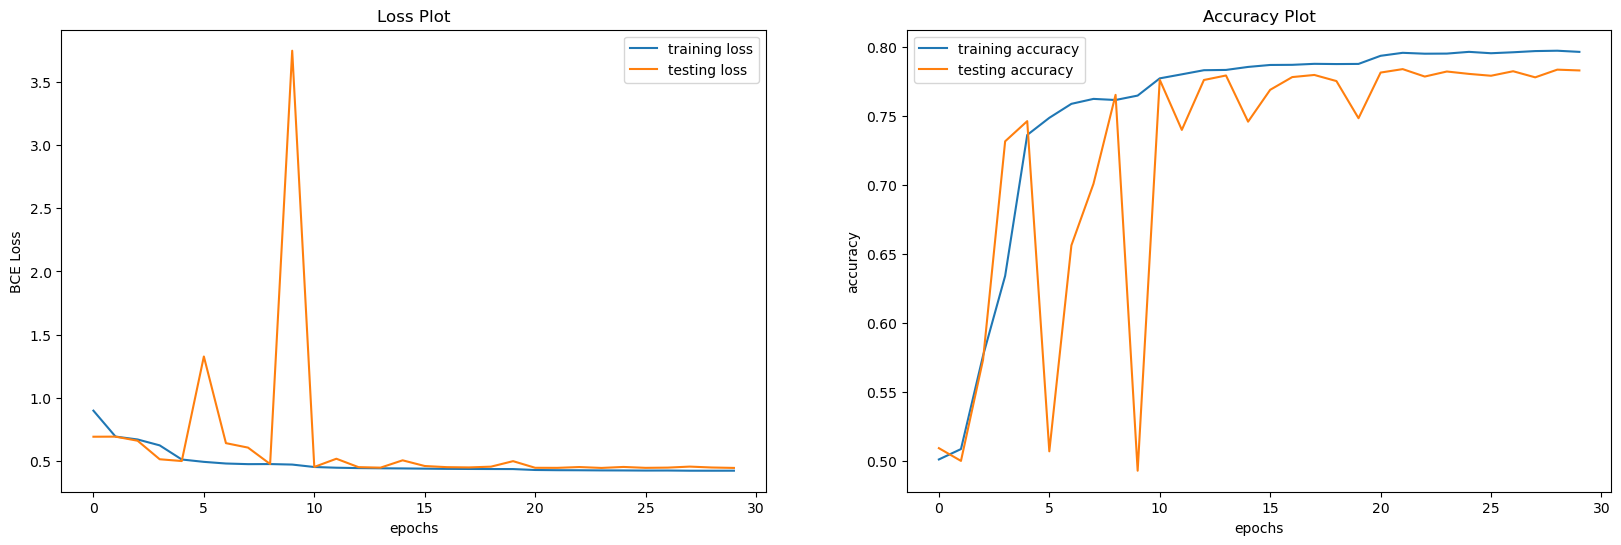

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

axs[0].plot(training_losses, label='training loss')
axs[0].plot(testing_losses, label='testing loss')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('BCE Loss')
axs[0].set_title('Loss Plot')
axs[0].legend()

axs[1].plot(training_accuracies, label='training accuracy')
axs[1].plot(testing_accuracies, label='testing accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[1].set_title('Accuracy Plot')
axs[1].legend()

# Model Evaluation

Finally, the model is evaluated on an evaluation set and the confusion matrix for classification is computed and plotted as shown below.

/opt/conda/lib/python3.10/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)
3it [00:16,  5.49s/it]

evaluation loss: 0.49798866113026935, 
evaluation accuracy: 75.0% 



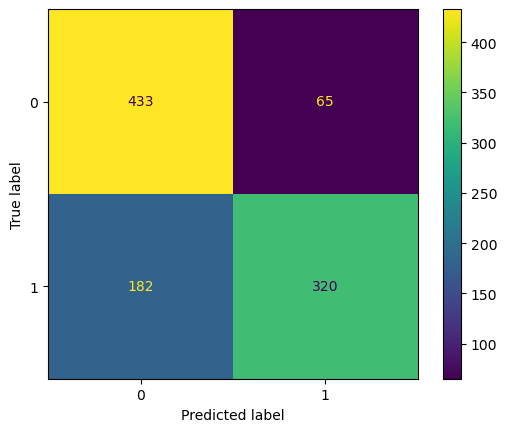

In [20]:

eval_n_samples = 1000
eval_dataset = SignalDataset(
    testing_paths[test_n_samples:test_n_samples+eval_n_samples],
    testing_ids[test_n_samples:test_n_samples+eval_n_samples])

eval_dataloader = DataLoader(eval_dataset, batch_size=Model_CFG.batch_size, shuffle=True, num_workers=0)


eval_loss, eval_acc, cm = classifier_pipeline.test(eval_dataloader, return_cm=True)

print(f'evaluation loss: {eval_loss}, \nevaluation accuracy: {round(eval_acc*100, 4)}% \n')

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cm_disp.plot()